In [0]:
%pip install fast_ml
%pip install tqdm
%pip install prophet

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
  Created wheel for pymeeus: filename=PyMeeus-0.5.11-py3-none-any.whl size=730984 sha256=4230860410b984b6f47b0e14bb202aba0ac41c6f1bee8e83d477bd8bed71c115
  Stored in directory: /root/.cache/pip/wheels/33/3d/82/4579e9cca41ff991140b2e050bc6df3a38292f26e4fa06b15d
Successfully built pymeeus
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Not uninstalling numpy at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-751967e6-3fc0-4f5a-ab95-abac785adcee
    Can't uninstall 'numpy'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.1 requires numpy<1.

In [0]:
import pandas as pd
import tqdm
import numpy as np
import matplotlib.pyplot as plt  
from datetime import datetime
import statistics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.ensemble import IsolationForest

/databricks/python/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


##Spliting data

In [0]:
df = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/DE_Simulation.csv", parse_dates=['ds'])
df_covid = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/Covid.csv")

In [0]:
activations = df[['ds', 'simulated']]
activations = activations.rename(columns={'simulated':'activations'})
activations['ds'] = pd.to_datetime(activations['ds'])
activations_index = activations.set_index(['ds'])
activations_index.head()

,activations
ds,
2018-01-07 00:00:00+00:00,5471.0
2018-01-14 00:00:00+00:00,5228.0
2018-01-21 00:00:00+00:00,5489.0
2018-01-28 00:00:00+00:00,5114.0
2018-02-04 00:00:00+00:00,6961.0


In [0]:
activations_index = activations_index.resample('W').sum().ffill()
activations_index.head()

,activations
ds,
2018-01-07 00:00:00+00:00,5471.0
2018-01-14 00:00:00+00:00,5228.0
2018-01-21 00:00:00+00:00,5489.0
2018-01-28 00:00:00+00:00,5114.0
2018-02-04 00:00:00+00:00,6961.0


In [0]:
before_covid_df = activations_index.iloc[0:113] ##from 2018-01-07 to 2020-03-01
in_covid_df = activations_index.iloc[113:217] ##from 2020-03-08 to 2022-02-27. >> two-year cycle
after_covid_df = activations_index.iloc[217:] ##from 2022-03-06 to 2022-08-28
no_covid_df = before_covid_df.append(after_covid_df)
print('before:',len(before_covid_df), ', in:',len(in_covid_df), ', after:', len(after_covid_df), ', no covid:', len(no_covid_df))

before: 113 , in: 104 , after: 26 , no covid: 139


#No Covid Part

In [0]:
no_covid_df = no_covid_df.reset_index()
no_covid_df = no_covid_df.rename(columns={'activations':'y'})

In [0]:
no_covid_df['ds'] = pd.date_range(start='2020-01-01', periods=139, freq='W') ##config the time index to fit in prophet ds

In [0]:
no_covid_df

,ds,y
0,2020-01-05,5471.0
1,2020-01-12,5228.0
2,2020-01-19,5489.0
3,2020-01-26,5114.0
4,2020-02-02,6961.0
...,...,...
134,2022-07-31,12145.0
135,2022-08-07,9118.0
136,2022-08-14,13552.0
137,2022-08-21,12309.0


Out[24]: <AxesSubplot:xlabel='ds'>

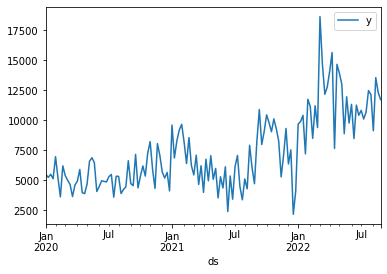

In [0]:
no_covid_df.set_index(['ds']).plot()

In [0]:
df_train = no_covid_df.iloc[:int(len(no_covid_df)*0.8)]
df_test = no_covid_df.iloc[int(len(no_covid_df)*0.8):]

#Prophet

In [0]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

##Baseline Model

08:05:51 - cmdstanpy - INFO - Chain [1] start processing
08:05:51 - cmdstanpy - INFO - Chain [1] done processing

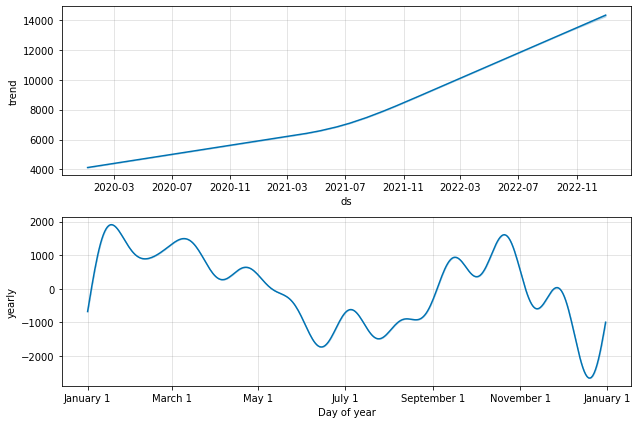

In [0]:
m = Prophet(
            # yearly_seasonality= False, 
            # weekly_seasonality= 'auto',
            # changepoint_prior_scale= 0.05,
            # seasonality_prior_scale=0.05,
            # holidays_prior_scale=10.0,
            # holidays= holidays,
            # seasonality_mode = 'multiplicative'
            )

# m.add_country_holidays(country_name='DE')
# m.add_seasonality('quarterly', period=91.25, fourier_order=5, mode='multiplicative')

# m.add_seasonality(name='yearly_on_season', period=365, fourier_order=10, condition_name='on_season', mode='multiplicative')
# m.add_seasonality(name='yearly_off_season', period=365, fourier_order=10, condition_name='off_season', mode='multiplicative')

m.fit(no_covid_df)
future = m.make_future_dataframe(18, freq='W')
# future['on_season'] = future['ds'].apply(is_nfl_season)
# future['off_season'] = ~future['ds'].apply(is_nfl_season)
forecast = m.predict(future)
fig = m.plot_components(forecast)

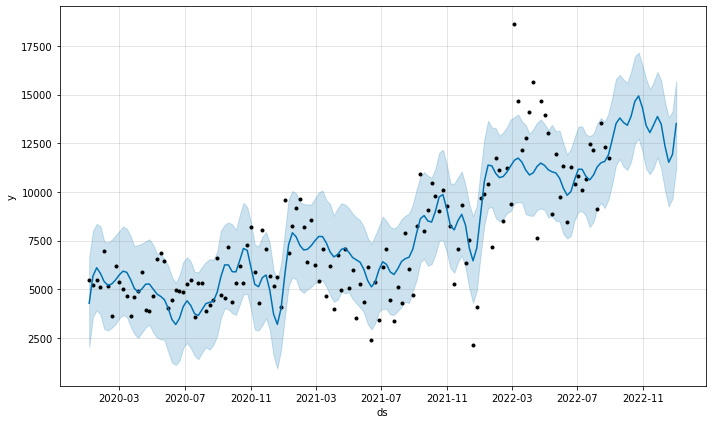

In [0]:
m.plot(forecast, uncertainty=True)
plt.show()

In [0]:
# Initial training period.
initial= 540
initial= str(initial)+' days'

#Period length that we perform the cross validation for.
period= 120
period=str(period)+' days'

#Horizon of prediction essentially for each fold.
horizon = 180
horizon=str(horizon)+' days'
fb_cv=cross_validation(m,initial=initial,period=period,
horizon=horizon)

# Performance Metrics of fb_cv
cv = performance_metrics(fb_cv)

cv

0%| | 0/3 [00:00<?, ?it/s]
08:05:53 - cmdstanpy - INFO - Chain [1] start processing
08:05:53 - cmdstanpy - INFO - Chain [1] done processing
08:05:54 - cmdstanpy - INFO - Chain [1] start processing
08:05:54 - cmdstanpy - INFO - Chain [1] done processing
08:05:55 - cmdstanpy - INFO - Chain [1] start processing
08:05:55 - cmdstanpy - INFO - Chain [1] done processing
Out[12]:

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,19 days,2.730852e+07,5225.755645,3911.205003,0.340727,0.382435,0.390529,0.428571
1,20 days,1.146840e+07,3386.502063,2520.498660,0.276490,0.300467,0.293370,0.571429
2,21 days,1.229454e+07,3506.356678,2837.340721,0.375754,0.382435,0.365466,0.428571
3,26 days,1.625383e+07,4031.604079,3439.775087,0.412313,0.422708,0.416041,0.285714
4,27 days,9.544773e+06,3089.461591,2625.845549,0.364046,0.382435,0.348117,0.428571
...,...,...,...,...,...,...,...,...
65,168 days,1.758109e+07,4192.980870,3089.730477,0.476523,0.179601,0.385520,0.571429
66,173 days,2.043377e+07,4520.372383,3620.476923,0.510595,0.369245,0.432682,0.428571
67,174 days,2.735647e+07,5230.341363,4408.144331,0.554611,0.427437,0.496635,0.285714
68,175 days,1.854998e+07,4306.968832,3588.212543,0.567018,0.427437,0.461581,0.285714


In [0]:
cv.mean() ##0

Out[13]: horizon 98 days 04:27:25.714285714
mse 15238040.495786
rmse 3809.090618
mae 3115.44156
mape 0.33502
mdape 0.304608
smape 0.350906
coverage 0.306122
dtype: object

In [0]:
from sklearn.metrics import mean_absolute_percentage_error,  r2_score, mean_squared_error

y_true = no_covid_df['y']
y_pred = forecast['yhat'].iloc[0:139]

print('mape:', mean_absolute_percentage_error(y_true, y_pred))
print('r2:', r2_score(y_true, y_pred))
print('RMSE', mean_squared_error(y_true, y_pred, squared=False))

mape: 0.22174204899530137
r2: 0.6845533968619038
RMSE 1745.7442591632785

## Adding Marketing Campaigns, Holidays and On-Season and Off-Season

In [0]:
real_holidays = pd.DataFrame({
  'holiday': 'real_holidays',
  'ds': pd.to_datetime(['2020-04-12', '2021-04-04', '2022-04-14', '2020-12-25', '2021-12-25', '2022-12-25']),
  'lower_window': -3,
  'upper_window': 3,
})
vacations = pd.DataFrame({
  'holiday': 'vacations',
  'ds': pd.to_datetime(['2020-07-05', '2021-08-05', '2020-07-05', '2021-08-05', '2022-07-05', '2022-08-05']),
  'lower_window': -15,
  'upper_window': 15,
})
compaigns = pd.DataFrame({
  'holiday': 'compaigns',
  'ds': pd.to_datetime(['2020-03-01', '2020-09-01', '2021-03-01', '2021-09-01', '2022-03-01', '2022-09-01']),
  'lower_window': 0,
  'upper_window': 15,
})
holidays = pd.concat((real_holidays, vacations, compaigns))

In [0]:
def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 8 or date.month < 6)

no_covid_df['on_season'] = no_covid_df['ds'].apply(is_nfl_season)
no_covid_df['off_season'] = ~no_covid_df['ds'].apply(is_nfl_season)

08:05:56 - cmdstanpy - INFO - Chain [1] start processing
08:05:56 - cmdstanpy - INFO - Chain [1] done processing
08:05:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
08:05:56 - cmdstanpy - INFO - Chain [1] start processing
08:05:57 - cmdstanpy - INFO - Chain [1] done processing

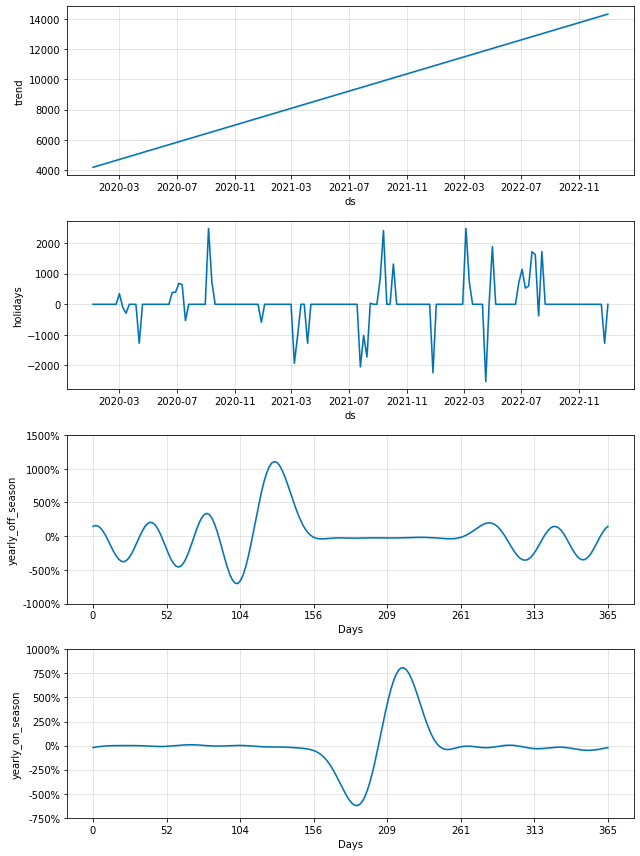

In [0]:
m1 = Prophet(
            yearly_seasonality= False, 
            weekly_seasonality= 'auto',
            changepoint_prior_scale= 0.01,
            #seasonality_prior_scale=0.05,
            holidays_prior_scale=0.1,
            holidays= holidays,
            seasonality_mode = 'additive'
            )

m1.add_country_holidays(country_name='DE')

m1.add_seasonality(name='yearly_on_season', period=365, fourier_order=10, condition_name='on_season', mode='multiplicative')
m1.add_seasonality(name='yearly_off_season', period=365, fourier_order=10, condition_name='off_season', mode='multiplicative')

m1.fit(no_covid_df)
future1 = m.make_future_dataframe(18, freq='W')
future1['on_season'] = future1['ds'].apply(is_nfl_season)
future1['off_season'] = ~future1['ds'].apply(is_nfl_season)
forecast1 = m1.predict(future1)
fig = m1.plot_components(forecast1)

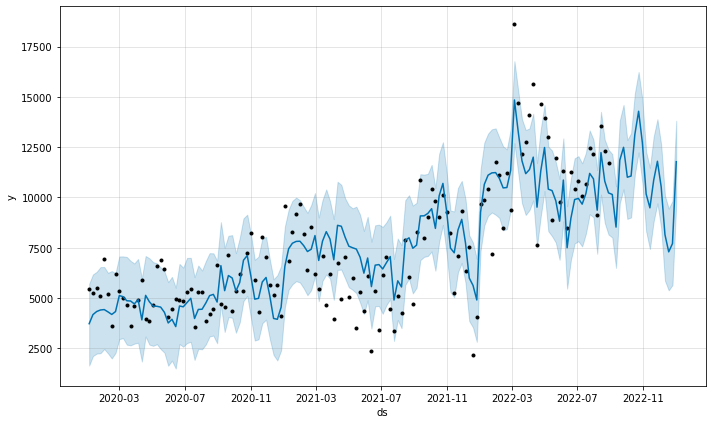

In [0]:
m1.plot(forecast1, uncertainty=True)
plt.show()

In [0]:
# Initial training period.
initial= 540
initial= str(initial)+' days'

#Period length that we perform the cross validation for.
period= 120
period=str(period)+' days'

#Horizon of prediction essentially for each fold.
horizon = 180
horizon=str(horizon)+' days'
fb_cv=cross_validation(m1,initial=initial,period=period,
horizon=horizon)

# Performance Metrics of fb_cv
cv = performance_metrics(fb_cv)

cv

0%| | 0/3 [00:00<?, ?it/s]
08:06:00 - cmdstanpy - INFO - Chain [1] start processing
08:06:04 - cmdstanpy - INFO - Chain [1] done processing
08:06:05 - cmdstanpy - INFO - Chain [1] start processing
08:06:05 - cmdstanpy - INFO - Chain [1] done processing
08:06:06 - cmdstanpy - INFO - Chain [1] start processing
08:06:06 - cmdstanpy - INFO - Chain [1] done processing
08:06:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
08:06:06 - cmdstanpy - INFO - Chain [1] start processing
08:06:07 - cmdstanpy - INFO - Chain [1] done processing
Out[19]:

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,19 days,3.147163e+07,5609.958019,4214.309209,0.369988,0.428537,0.427435,0.285714
1,20 days,1.439238e+07,3793.729397,2826.847448,0.311828,0.382626,0.331703,0.428571
2,21 days,1.537729e+07,3921.388354,3173.946997,0.420333,0.428537,0.408604,0.285714
3,26 days,2.098211e+07,4580.623779,3951.330970,0.473254,0.495673,0.483662,0.142857
4,27 days,1.237460e+07,3517.754338,2961.674730,0.410846,0.428537,0.394402,0.285714
...,...,...,...,...,...,...,...,...
65,168 days,1.782611e+07,4222.097676,3222.405978,0.494096,0.225996,0.404387,0.285714
66,173 days,2.173855e+07,4662.462296,3840.814023,0.533446,0.432834,0.462455,0.142857
67,174 days,2.910277e+07,5394.698722,4613.531931,0.573936,0.450398,0.523704,0.142857
68,175 days,2.156442e+07,4643.750730,3940.957112,0.615189,0.450398,0.507709,0.142857


In [0]:
cv.mean() ##0

Out[20]: horizon 98 days 04:27:25.714285714
mse 17748227.676288
rmse 4123.821442
mae 3329.827731
mape 0.361984
mdape 0.328816
smape 0.382984
coverage 0.35102
dtype: object

In [0]:
from sklearn.metrics import mean_absolute_percentage_error,  r2_score, mean_squared_error

y_true = no_covid_df['y']
y_pred = forecast1['yhat'].iloc[0:139]

print('mape:', mean_absolute_percentage_error(y_true, y_pred))
print('r2:', r2_score(y_true, y_pred))
print('RMSE', mean_squared_error(y_true, y_pred, squared=False))

mape: 0.21895048268733197
r2: 0.7275431747411472
RMSE 1622.432139574641

In [0]:
# Python
import itertools
import numpy as np
import pandas as pd

def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 8 or date.month < 6)

no_covid_df['on_season'] = no_covid_df['ds'].apply(is_nfl_season)
no_covid_df['off_season'] = ~no_covid_df['ds'].apply(is_nfl_season)

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5],
    'holidays_prior_scale': [0.1, 1.0, 5.0, 10],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mape = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m1 = Prophet(**params, holidays=holidays)
    m1.add_seasonality(name='yearly_on_season', period=365, fourier_order=10, condition_name='on_season')
    m1.add_seasonality(name='yearly_off_season', period=365, fourier_order=10, condition_name='off_season')
    m1.add_country_holidays(country_name='DE')
    m1.fit(no_covid_df)  # Fit model with given params

    df_cv = cross_validation(m1, initial='540 days', period='120 days', horizon='180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mape.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mape
print(tuning_results)

08:06:09 - cmdstanpy - INFO - Chain [1] start processing
08:06:09 - cmdstanpy - INFO - Chain [1] done processing
08:06:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
08:06:09 - cmdstanpy - INFO - Chain [1] start processing
08:06:11 - cmdstanpy - INFO - Chain [1] done processing
08:06:16 - cmdstanpy - INFO - Chain [1] start processing
08:06:16 - cmdstanpy - INFO - Chain [1] done processing
08:06:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
08:06:16 - cmdstanpy - INFO - Chain [1] start processing
08:07:00 - cmdstanpy - INFO - Chain [1] done processing
08:08:40 - cmdstanpy - INFO - Chain [1] start processing
08:08:40 - cmdstanpy - INFO - Chain [1] done processing
08:08:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
08:08:40 - cmdstanpy - INFO - Chain [1] start processing
08:08:43 - cmdstanpy - INFO - Chain [1] done processing
08:08:56 - cmdstanpy - INFO - Chain [1] start processing
08:08:56 - cmdstanpy - INFO - Chain [1] done processing
08:08:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
08:08:56 - cmdstanpy - INFO - Chain [1] start processing
08:09:02 - cmdstanpy - INFO - Chain [1] done processing
08:12:33 - cmdstanpy - INFO - Chain [1] start processing
08:12:33 - cmdstanpy - INFO - Chain [1] done processing
08:12:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
08:12:33 - cmdstanpy - INFO - Chain [1] start processing
08:12:34 - cmdstanpy - INFO - Chain [1] done processing
08:12:55 - cmdstanpy - INFO - Chain [1] start processing
08:12:55 - cmdstanpy - INFO - Chain [1] done processing
08:12:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
08:12:55 - cmdstanpy - INFO - Chain [1] start processing
08:13:05 - cmdstanpy - INFO - Chain [1] done processing
08:17:52 - cmdstanpy - INFO - Chain [1] start processing
08:17:52 - cmdstanpy - INFO - Chain [1] done processing
08:17:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
08:17:52 - cmdstanpy - INFO - Chain [1] start processing
08:17:53 - cmdstanpy - INFO - Chain [1] done processing
08:18:04 - cmdstanpy - INFO - Chain [1] start processing
08:18:04 - cmdstanpy - INFO - Chain [1] done processing
08:18:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
08:18:04 - cmdstanpy - INFO - Chain [1] start processing
08:18:13 - cmdstanpy - INFO - Chain [1] done processing
08:21:02 - cmdstanpy - INFO - Chain [1] start processing
08:21:02 - cmdstanpy - INFO - Chain [1] done processing
08:21:04 - cmdstanpy - INFO - Chain [1] start processing
08:21:04 - cmdstanpy - INFO - Chain [1] done processing
08:21:07 - cmdstanpy - INFO - Chain [1] start processing
08:21:07 - cmdstanpy - INFO - Chain [1] done processing
08:21:10 - cmdstanpy - INFO - Chain [1] start processing
08:21:10 - cmdstanpy - INFO - Chain [1] done processing
08:21:17 - cmdstanpy - INFO - Chain [1] start processing
08:21:17 - cmdstanpy - INFO - Chain [1] done processing
08:21:19 - cmdstanpy - INFO - Chain [1] start processing
08:21:19 - cmdstanpy - INFO - Chain [1] done processing
08:21:25 - cmdstanpy - INFO - Chain [1] start processing
08:21:25 - cmdstanpy - INFO - Chain [1] done processing
08:21:28 - cmdstanpy - INFO - Chain [1] start processing
08:21:28 - cmdstanpy - INFO - Chain [1] done processing
08:21:51

In [0]:
best_params = all_params[np.argmin(mape)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}

## Adding Seasonality

08:24:38 - cmdstanpy - INFO - Chain [1] start processing
08:24:38 - cmdstanpy - INFO - Chain [1] done processing

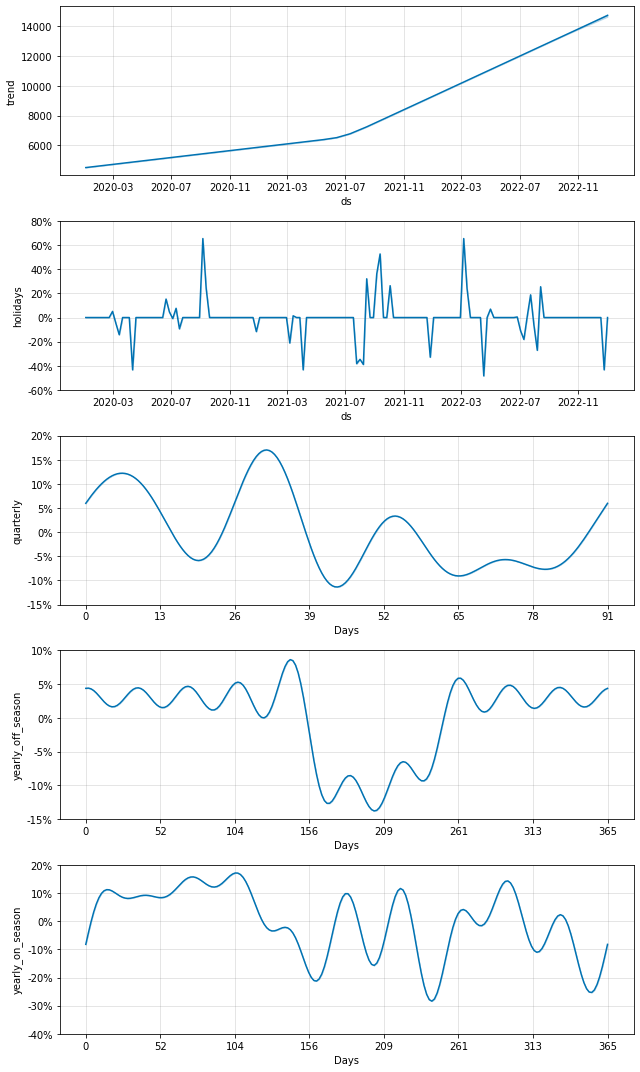

In [0]:
m2 = Prophet(
            yearly_seasonality= False, 
            weekly_seasonality= 'auto',
            changepoint_prior_scale= 0.05,
            seasonality_prior_scale=0.05,
            holidays_prior_scale=10.0,
            holidays= holidays,
            seasonality_mode = 'multiplicative'
            )

m2.add_country_holidays(country_name='DE')
m2.add_seasonality('quarterly', period=91.25, fourier_order=5, mode='multiplicative')

m2.add_seasonality(name='yearly_on_season', period=365, fourier_order=10, condition_name='on_season', mode='multiplicative')
m2.add_seasonality(name='yearly_off_season', period=365, fourier_order=10, condition_name='off_season', mode='multiplicative')

m2.fit(no_covid_df)
future2 = m2.make_future_dataframe(18, freq='W')
future2['on_season'] = future2['ds'].apply(is_nfl_season)
future2['off_season'] = ~future2['ds'].apply(is_nfl_season)
forecast2 = m2.predict(future2)
fig = m2.plot_components(forecast2)

In [0]:
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Out[25]:

,ds,yhat,yhat_lower,yhat_upper
152,2022-12-04,12699.355144,11059.903029,14159.467773
153,2022-12-11,11245.754763,9573.339593,12830.194251
154,2022-12-18,9823.165553,8230.921434,11413.303855
155,2022-12-25,4635.901775,3094.283350,6200.141409
156,2023-01-01,14969.440958,13332.250967,16507.784576


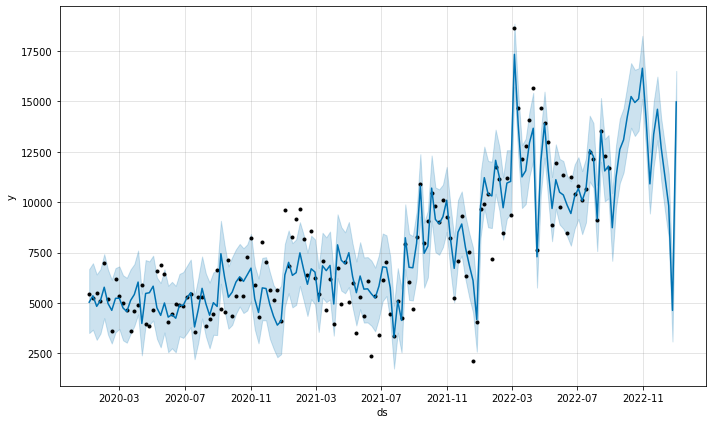

In [0]:
m2.plot(forecast2, uncertainty=True)
plt.show()

In [0]:
# Initial training period.
initial= 540
initial= str(initial)+' days'

#Period length that we perform the cross validation for.
period= 120
period=str(period)+' days'

#Horizon of prediction essentially for each fold.
horizon = 180
horizon=str(horizon)+' days'
fb_cv=cross_validation(m2,initial=initial,period=period,
horizon=horizon)

# Performance Metrics of fb_cv
cv = performance_metrics(fb_cv)

cv

0%| | 0/3 [00:00<?, ?it/s]
08:24:41 - cmdstanpy - INFO - Chain [1] start processing
08:24:43 - cmdstanpy - INFO - Chain [1] done processing
08:24:44 - cmdstanpy - INFO - Chain [1] start processing
08:24:46 - cmdstanpy - INFO - Chain [1] done processing
08:24:47 - cmdstanpy - INFO - Chain [1] start processing
08:24:47 - cmdstanpy - INFO - Chain [1] done processing
Out[27]:

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,19 days,4.036304e+07,6353.191057,4586.442281,0.384380,0.452169,0.474377,0.285714
1,20 days,1.924738e+07,4387.183404,3007.553704,0.314222,0.301238,0.356845,0.428571
2,21 days,2.096985e+07,4579.285142,3424.037507,0.453631,0.452169,0.444216,0.285714
3,26 days,2.583833e+07,5083.141769,4245.418821,0.517190,0.457485,0.527169,0.142857
4,27 days,1.242411e+07,3524.784582,2973.535465,0.435212,0.452169,0.398965,0.285714
...,...,...,...,...,...,...,...,...
65,168 days,1.886020e+07,4342.833060,3177.494145,0.524442,0.122982,0.396809,0.571429
66,173 days,2.208911e+07,4699.905579,3791.293898,0.569054,0.388217,0.455175,0.428571
67,174 days,3.028271e+07,5502.973215,4759.533356,0.630096,0.464857,0.541640,0.285714
68,175 days,2.430715e+07,4930.228688,4195.894123,0.680333,0.519677,0.537953,0.285714


In [0]:
cv.mean() ##0

Out[28]: horizon 98 days 04:27:25.714285714
mse 17606359.366285
rmse 4034.797293
mae 3210.112066
mape 0.355942
mdape 0.314567
smape 0.366587
coverage 0.308163
dtype: object

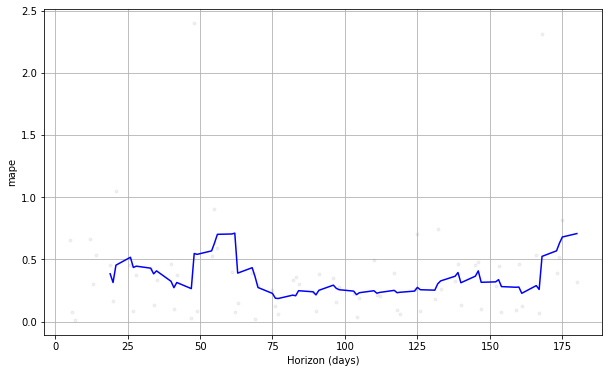

In [0]:
plot_cross_validation_metric(fb_cv,'mape');

In [0]:
# Python
import itertools
import numpy as np
import pandas as pd

def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 9 or date.month < 6)

no_covid_df['on_season'] = no_covid_df['ds'].apply(is_nfl_season)
no_covid_df['off_season'] = ~no_covid_df['ds'].apply(is_nfl_season)

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5.0, 10.0],
    'holidays_prior_scale': [0.1, 1.0, 5.0, 10],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mape = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m2 = Prophet(**params, holidays=holidays)
    m2.add_seasonality(name='yearly_on_season', period=365, fourier_order=10, condition_name='on_season')
    m2.add_seasonality(name='yearly_off_season', period=365, fourier_order=10, condition_name='off_season')
    m2.add_seasonality('quarterly', period=91.25, fourier_order=5, mode='additive')
    m2.add_country_holidays(country_name='DE')
    m2.fit(no_covid_df)  # Fit model with given params

    df_cv = cross_validation(m2, initial='548 days', period='130 days', horizon='10 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mape.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mape
print(tuning_results)

08:24:48 - cmdstanpy - INFO - Chain [1] start processing
08:24:48 - cmdstanpy - INFO - Chain [1] done processing
08:24:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
08:24:48 - cmdstanpy - INFO - Chain [1] start processing
08:24:50 - cmdstanpy - INFO - Chain [1] done processing
08:24:53 - cmdstanpy - INFO - Chain [1] start processing
08:24:53 - cmdstanpy - INFO - Chain [1] done processing
08:24:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
08:24:53 - cmdstanpy - INFO - Chain [1] start processing
08:24:55 - cmdstanpy - INFO - Chain [1] done processing
08:24:58 - cmdstanpy - INFO - Chain [1] start processing
08:24:58 - cmdstanpy - INFO - Chain [1] done processing
08:24:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
08:24:58 - cmdstanpy - INFO - Chain [1] start processing
08:24:59 - cmdstanpy - INFO - Chain [1] done processing
08:25:09 - cmdstanpy - INFO - Chain [1] start processing
08:25:09 - cmdstanpy - INFO - Chain [1] done processing
08:25:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
08:25:09 - cmdstanpy - INFO - Chain [1] start processing
08:25:14 - cmdstanpy - INFO - Chain [1] done processing
08:25:18 - cmdstanpy - INFO - Chain [1] start processing
08:25:18 - cmdstanpy - INFO - Chain [1] done processing
08:25:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
08:25:18 - cmdstanpy - INFO - Chain [1] start processing
08:25:20 - cmdstanpy - INFO - Chain [1] done processing
08:25:59 - cmdstanpy - INFO - Chain [1] start processing
08:25:59 - cmdstanpy - INFO - Chain [1] done processing
08:25:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
08:25:59 - cmdstanpy - INFO - Chain [1] start processing
08:26:01 - cmdstanpy - INFO - Chain [1] done processing
08:26:05 - cmdstanpy - INFO - Chain [1] start processing
08:26:05 - cmdstanpy - INFO - Chain [1] done processing
08:26:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
08:26:05 - cmdstanpy - INFO - Chain [1] start processing
08:26:07 - cmdstanpy - INFO - Chain [1] done processing
08:26:13 - cmdstanpy - INFO - Chain [1] start processing
08:26:13 - cmdstanpy - INFO - Chain [1] done processing
08:26:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
08:26:13 - cmdstanpy - INFO - Chain [1] start processing
08:26:15 - cmdstanpy - INFO - Chain [1] done processing
08:26:21 - cmdstanpy - INFO - Chain [1] start processing
08:26:21 - cmdstanpy - INFO - Chain [1] done processing
08:26:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
08:26:21 - cmdstanpy - INFO - Chain [1] start processing
08:26:28 - cmdstanpy - INFO - Chain [1] done processing
08:26:32 - cmdstanpy - INFO - Chain [1] start processing
08:26:32 - cmdstanpy - INFO - Chain [1] done processing
08:26:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
08:26:32 - cmdstanpy - INFO - Chain [1] start processing
08:26:34 - cmdstanpy - INFO - Chain [1] done processing
08:26:40 - cmdstanpy - INFO - Chain [1] start processing
08:26:40 - cmdstanpy - INFO - Chain [1] done processing
08:26:40 - cmdstanpy - ERRO

In [0]:
best_params = all_params[np.argmin(mape)]
print(best_params)

{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}

In [0]:
def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 9 or date.month < 5)

no_covid_df['on_season'] = no_covid_df['ds'].apply(is_nfl_season)
no_covid_df['off_season'] = ~no_covid_df['ds'].apply(is_nfl_season)

## Forecasts

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps82jhoft/2c1_g90a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps82jhoft/lbpdghlx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/local_disk0/.ephemeral_nfs/envs/pythonEnv-ffd54b80-8c52-47c3-b4d3-11e2789e6c22/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20967', 'data', 'file=/tmp/tmps82jhoft/2c1_g90a.json', 'init=/tmp/tmps82jhoft/lbpdghlx.json', 'output', 'file=/tmp/tmps82jhoft/prophet_model_pujp5ol/prophet_model-20221203155817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:58:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:58:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanp

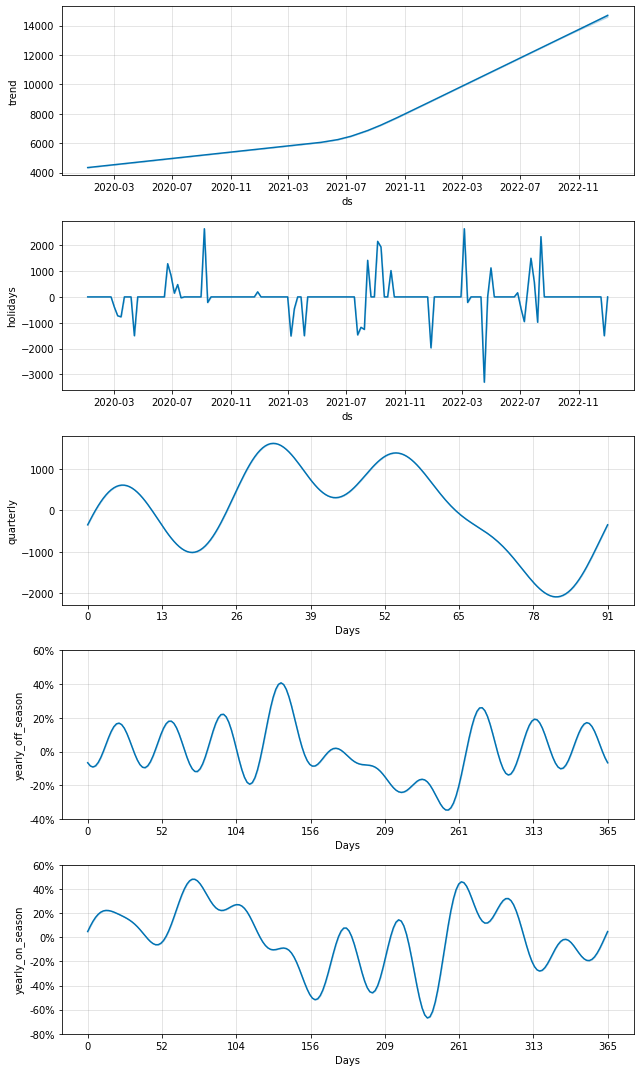

In [0]:
m4 = Prophet(yearly_seasonality= False, 
                        weekly_seasonality= 'auto',
                        changepoint_prior_scale= 0.05,
                        seasonality_prior_scale=5.0,
                        holidays_prior_scale=0.1,
                        holidays= holidays,
                        seasonality_mode = 'additive')

m4.add_seasonality(name='yearly_on_season', period=365, fourier_order=10, condition_name='on_season', mode='multiplicative')
m4.add_seasonality(name='yearly_off_season', period=365, fourier_order=10, condition_name='off_season', mode='multiplicative')

m4.add_seasonality('quarterly', period=91.25, fourier_order=5, mode='additive')
m4.add_country_holidays(country_name='DE')

m4.fit(no_covid_df)
future4 = m4.make_future_dataframe(18, freq='W')

future4['on_season'] = future4['ds'].apply(is_nfl_season)
future4['off_season'] = ~future4['ds'].apply(is_nfl_season)

forecast4 = m4.predict(future4)
fig = m4.plot_components(forecast4)

In [0]:
forecast4[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
152,2022-12-04,13866.732218,12227.420753,15476.864776
153,2022-12-11,11780.085115,10137.278200,13419.131802
154,2022-12-18,9921.530120,8273.243090,11525.088811
155,2022-12-25,9712.884416,8040.339320,11292.258767
156,2023-01-01,15664.027685,14051.289802,17153.667445


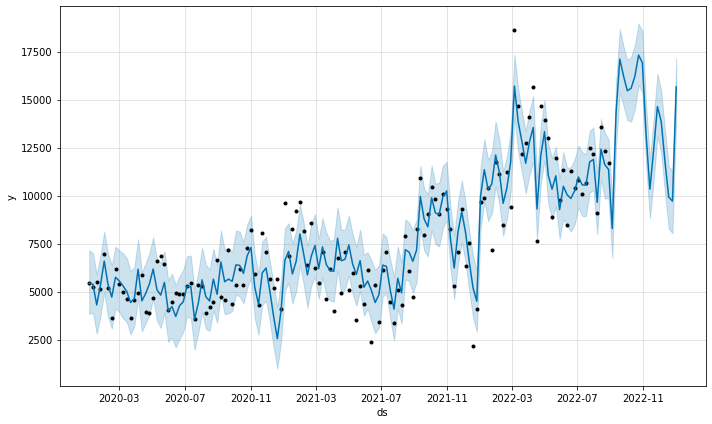

In [0]:
m4.plot(forecast4, uncertainty=True)
plt.show()

In [0]:
from sklearn.metrics import mean_absolute_percentage_error,  r2_score, mean_squared_error

y_true = no_covid_df['y']
y_pred = forecast4['yhat'].iloc[0:139]

print('mape:', mean_absolute_percentage_error(y_true, y_pred))
print('r2:', r2_score(y_true, y_pred))
print('RMSE', mean_squared_error(y_true, y_pred, squared=False))

mape: 0.16242422808392812
r2: 0.8401638344123243
RMSE 1242.6683040866126


In [0]:
# Initial training period.
initial= 540
initial= str(initial)+' days'

#Period length that we perform the cross validation for.
period= 120
period=str(period)+' days'

#Horizon of prediction essentially for each fold.
horizon = 180
horizon=str(horizon)+' days'
fb_cv=cross_validation(m4,initial=initial,period=period,
horizon=horizon)

# Performance Metrics of fb_cv
cv = performance_metrics(fb_cv)

cv

INFO:prophet:Making 3 forecasts with cutoffs between 2021-07-04 00:00:00 and 2022-03-01 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmps82jhoft/fx4y1oj5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps82jhoft/wvlnol2h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/local_disk0/.ephemeral_nfs/envs/pythonEnv-ffd54b80-8c52-47c3-b4d3-11e2789e6c22/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30341', 'data', 'file=/tmp/tmps82jhoft/fx4y1oj5.json', 'init=/tmp/tmps82jhoft/wvlnol2h.json', 'output', 'file=/tmp/tmps82jhoft/prophet_model0rxro7z_/prophet_model-20221203155826.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:58:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:58:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmps82jhoft/ttv79l4i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps82jhoft/n2lc3aci.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running C

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,19 days,3.515130e+07,5928.853097,4294.708091,0.362257,0.445572,0.431476,0.428571
1,20 days,1.662525e+07,4077.406842,2812.481553,0.296043,0.150050,0.324977,0.571429
2,21 days,1.868344e+07,4322.434247,3219.767989,0.445090,0.445572,0.410369,0.428571
3,26 days,2.462484e+07,4962.342446,4140.746655,0.517236,0.505330,0.506921,0.285714
4,27 days,1.391376e+07,3730.115602,2999.571046,0.443467,0.445572,0.398093,0.428571
...,...,...,...,...,...,...,...,...
65,168 days,1.693545e+07,4115.270507,3173.785005,0.470657,0.230584,0.404762,0.285714
66,173 days,2.063712e+07,4542.809291,3855.375098,0.522433,0.401919,0.471814,0.142857
67,174 days,2.758753e+07,5252.383193,4595.756789,0.560470,0.414414,0.529017,0.142857
68,175 days,2.254244e+07,4747.887827,3991.295983,0.575168,0.496838,0.514741,0.142857


In [0]:
cv.mean() ##0

Out[25]: horizon     98 days 04:27:25.714285714
mse                     18455009.62503
rmse                       4184.057349
mae                        3338.422604
mape                          0.359627
mdape                         0.340664
smape                         0.386354
coverage                      0.232653
dtype: object

#Do

In [0]:
future_forecast = forecast4[['ds', 'yhat']]
future_forecast = future_forecast[future_forecast['ds'] < '2022-11-21']
future_forecast = future_forecast[future_forecast['ds'] > '2022-08-31']
future_forecast = future_forecast.set_index(['ds'])
future_forecast

,yhat
ds,
2022-09-04,8285.069502
2022-09-11,14287.600792
2022-09-18,17107.423203
2022-09-25,16228.067771
2022-10-02,15460.456580
2022-10-09,15586.550125
2022-10-16,16208.840203
2022-10-23,17317.766090
2022-10-30,16914.745217


In [0]:
future_real = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/W_input.csv", parse_dates=['ds'])
future_real = future_real[['ds', 'simulated']]
future_real.head()

,ds,simulated
0,2022-08-07 00:00:00+00:00,9530
1,2022-08-14 00:00:00+00:00,9602
2,2022-08-21 00:00:00+00:00,10011
3,2022-08-28 00:00:00+00:00,10759
4,2022-09-04 00:00:00+00:00,13129


In [0]:
future_real = future_real[future_real['ds'] > '2022-09-01']
# future_real_df = future_real_df[['ds', '']]
future_real_df_index = future_real.set_index(['ds'])
future_real_df_index

,simulated
ds,
2022-09-04 00:00:00+00:00,13129
2022-09-11 00:00:00+00:00,13101
2022-09-18 00:00:00+00:00,11780
2022-09-25 00:00:00+00:00,10800
2022-10-02 00:00:00+00:00,10426
2022-10-09 00:00:00+00:00,11367
2022-10-16 00:00:00+00:00,11168
2022-10-23 00:00:00+00:00,11180
2022-10-30 00:00:00+00:00,11349


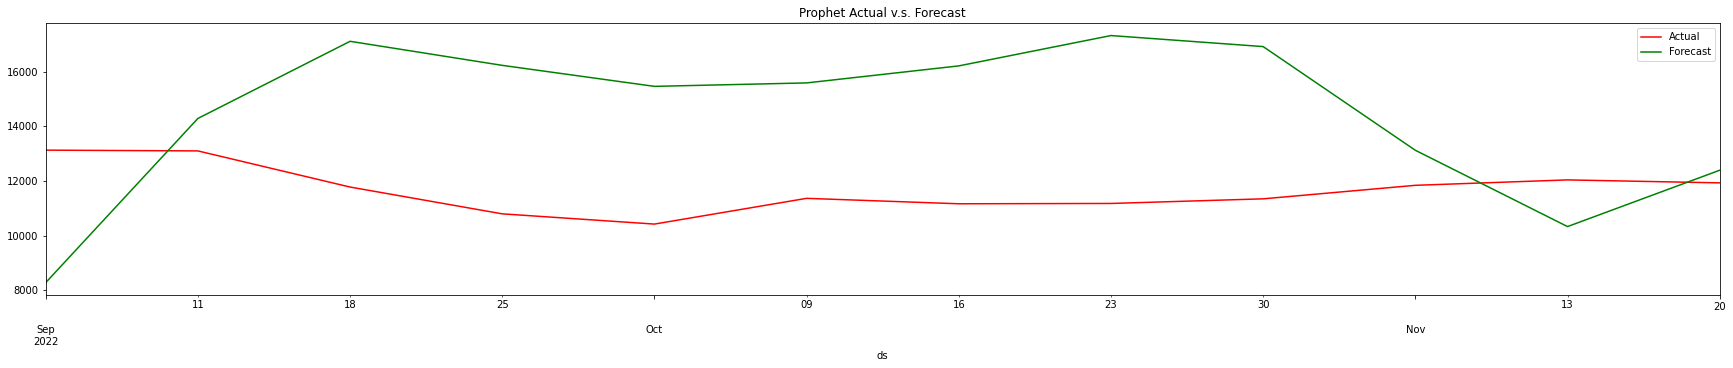

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

future_real_df_index.plot(kind='line',y='simulated', color='red', label='Actual', ax=ax)
future_forecast.plot(kind='line',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Prophet Actual v.s. Forecast')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import mean_absolute_percentage_error,  r2_score, mean_squared_error

y_true = future_real_df_index
y_pred = future_forecast

print('mape:', mean_absolute_percentage_error(y_true, y_pred))
print('r2:', r2_score(y_true, y_pred))
print('RMSE', mean_squared_error(y_true, y_pred, squared=False))

mape: 0.33731050085426756
r2: -29.297541810457144
RMSE 4327.161600541934
